<a href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/shooting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shooting Methods

<a target="_blank" href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/shooting.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

These methods use numerical optimizers to design trajectories.  We have to design cost function and constraints that define the trajectories we want.  For example, we might look for the shortest path that respects the limits of our vehicle.  In these examples we'll use curvature limits, which are somewhat represenative of a fixed-wing aircraft problem.

The first method studied is _single shooting_ where the cost is found by integrating candidate decisions forward from the starting point.  Later we'll look at _multiple shooting_ where the integration is done over multiple segments.  Although it makes the optimization larger in terms of number of decision variables, it actually makes it easier to solve in many cases.

## Single Shooting

### Problem definition

We start by defining a start and goal pose.  These include heading angle as well as position.

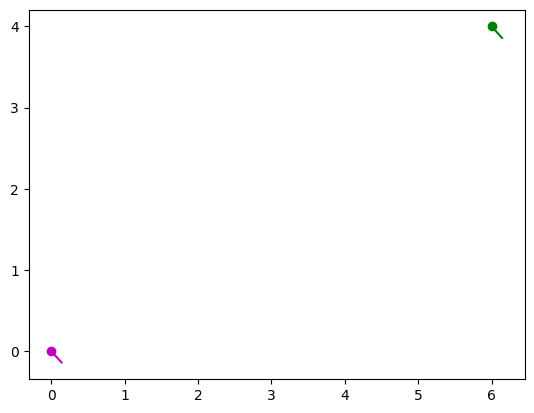

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import cos,sin

x0 = np.array([0,0,-np.pi/4.])
xG = np.array([6.,4.,-np.pi/4])


def plot_pose(x,col):
  # small length just for plotting
  d = np.array([0,0.2])
  # plot a dot with a pointing line
  plt.plot(x[0]+d*cos(x[2]),x[1]+d*sin(x[2]),col)
  plt.plot(x[0],x[1],col+'o')

plot_pose(x0,'m')
plot_pose(xG,'g')

plt.show()

### Dynamics model

Assuming the vehicle obeys a dynamic model of the form $\dot{x}=f(x,u)$, define the function $f$.

In [2]:
def f(x,u):
    return(np.array([u[0]*cos(x[2]),u[0]*sin(x[2]),u[0]*u[1]]))

Now, define a function that takes a sequence of time intervals and curvature commands, and integrates a path forward from the starting pose.

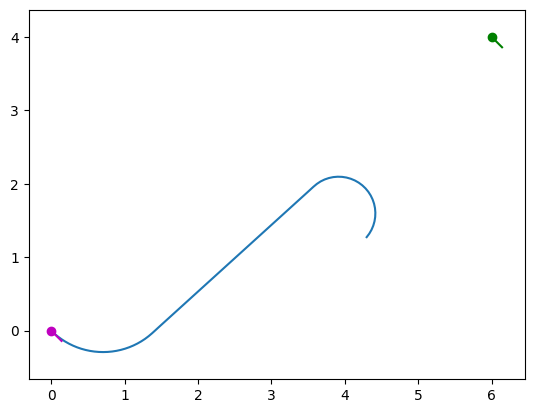

In [3]:
# define decision variable as vector of [time,curv,time,curv,time,curv]
# here: turn with curvature 1. for 1.5 seconds, than 0. (straight) for 3. seconds, and finally turn with curvature -1. for 1.5 seconds.
z = np.array([1.5,1.,3.,0.,1.5,-2.])

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

def path(z,x0):
    # make sure it has even number of elements
    nz = len(z)
    assert(nz%2==0)
    # curvature values
    kv = z[range(1,nz,2)]
    # time intervals
    dv = z[range(0,nz,2)]
    # if given a negative time intervals, make it zero
    dv = [max(v,0) for v in dv]
    # now construct function to interpolate commands over time
    nv = len(kv)
    uv = np.vstack((np.ones((1,nv+1)),np.hstack((kv,0.))))
    tv = np.cumsum(np.append(0,dv))
    te=np.linspace(0.,max(tv),100)
    ut = interp1d(tv,uv,axis=1,kind='previous',bounds_error=False,fill_value='extrapolate')
    # use this to define the uncontrolled dynamics: x-dot=fc(x,t)
    def fc(t,x):
        u = ut(t)
        return(f(x,u))
    # and do the integration
    r = solve_ivp(fc,(min(te),max(te)),x0,t_eval=te)
    return(r.y)

p = path(z,x0)

plt.plot(p[0,:],p[1,:])
plot_pose(x0,'m')
plot_pose(xG,'g')
plt.axis('equal')
plt.show()

OK, we have a path, but it gets nowhere near the goal yet as we haven't optimized anything.

Next, define a cost function combining three terms:

1. The total flight time, found by summing up the time intervals in the decision variable.  This is the primary cost.
2. A penalty for missing the goal at the end.
3. A penalty for using more than the available curvature.

In [4]:
from scipy.linalg import norm
curvature_limit = 1.5

def path_cost(z):
    p = path(z,x0)
    goal_miss_distance = norm(p[0:3,-1]-xG)
    total_time_flown = sum(z[range(0,len(z),2)])
    curvature_excess = [max(abs(c)-curvature_limit,0.) for c in z[range(1,len(z),2)]]
    J = total_time_flown + 1000.*goal_miss_distance + 10000.*sum(curvature_excess)
    return(J)

print(path_cost(z))

8545.530604540565


Having defined the cost, we pass it to one of the built-in optimizers.

In [5]:
from scipy.optimize import minimize

r = minimize(path_cost,z,method='Powell')
print(r)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 8.125297155480473
       x: [ 1.928e+00  8.645e-01  5.132e+00  1.239e-04  1.065e+00
           -1.500e+00]
     nit: 13
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 1618


And now plot the result, showing the original guess for comparison.

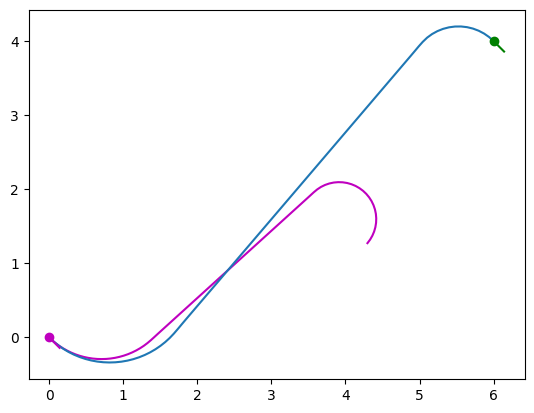

In [6]:
popt = path(r.x,x0)
plt.plot(p[0,:],p[1,:],'m')
plt.plot(popt[0,:],popt[1,:])
plot_pose(x0,'m')
plot_pose(xG,'g')
plt.axis('equal')
plt.show()

## Multiple Shooting

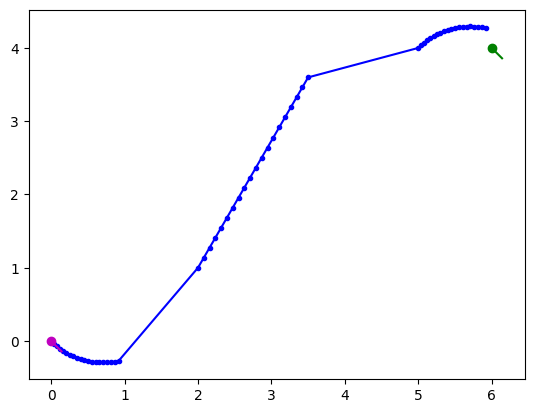

In [10]:
# define decision variable as vector of [time,curv,state,time,curv,state,time,curv]
zm = np.array([1.,1.,   2.,1.,np.pi/3,3.,0.,   5.,4.,np.pi/4,1.,-1.])

def pathm(z):
    # make sure it has N*5 + 2 elements
    nz = len(z)
    assert((nz-2)%5==0)
    # initial curvature values
    ix = 0
    xs = np.array([x0])
    xi = x0
    while ix<nz:
        def fm(t,x):
            u = np.array([1.,z[ix+1]])
            return(f(x,u))
        te=np.linspace(0.,z[ix],20)
        r = solve_ivp(fm,(0.,z[ix]),xi,t_eval=te)
        xs = np.append(xs,np.transpose(r.y),0)
        ix = ix+5
        xi = z[(ix-3):ix]
    return(xs)

p = pathm(zm)

plt.plot(p[:,0],p[:,1],'-b.')
plot_pose(x0,'m')
plot_pose(xG,'g')
plt.axis('equal')
plt.show()

In [11]:
def Jm(z):
    tf = sum(z[range(0,len(z),5)])
    p = pathm(z)
    ge = norm(xG-p[-1,:])
    for ii in range(20,len(p)-1,20):
        ge=ge+norm(p[ii,:]-p[ii+1,:])
    return(0.1*tf+100.*ge)

print(Jm(zm))

407.96823232122074


In [13]:
x_lim = 10
th_lim = np.pi
bndsm = [b for ii in range(len(z)//2) for b in [(0.1,10.0),(-curvature_limit,curvature_limit),(-x_lim,x_lim),(-x_lim,x_lim),(-th_lim,th_lim)]]
bndsm = bndsm[0:-3]
assert(len(bndsm)==len(zm))
bndsm

[(0.1, 10.0),
 (-1.5, 1.5),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (0.1, 10.0),
 (-1.5, 1.5),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (0.1, 10.0),
 (-1.5, 1.5)]

In [14]:
r = minimize(Jm,zm,method='SLSQP',bounds=bndsm)
print(r)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.8768335498297386
       x: [ 2.118e+00  9.123e-01  1.774e+00  3.244e-01  1.147e+00
            3.881e+00 -3.666e-02  3.616e+00  3.737e+00  1.005e+00
            2.752e+00 -6.506e-01]
     nit: 54
     jac: [-4.948e+01 -9.925e+01 -2.163e+01  1.603e+02  2.054e+02
            4.714e+01  6.165e+02  1.027e+02 -2.558e+01  1.339e+01
            2.715e+01  2.358e+02]
    nfev: 821
    njev: 54


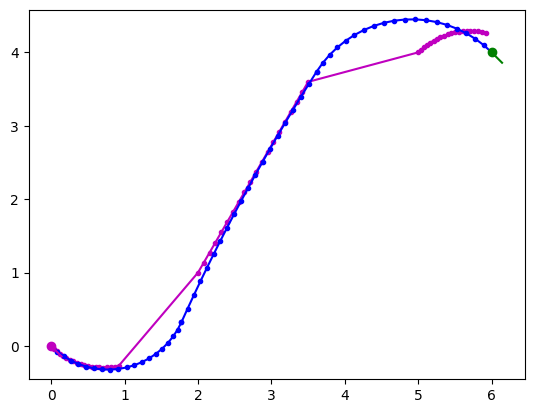

In [15]:
popt = pathm(r.x)

plt.plot(p[:,0],p[:,1],'-m.')
plt.plot(popt[:,0],popt[:,1],'-b.')
plot_pose(x0,'m')
plot_pose(xG,'g')
plt.axis('equal')
plt.show()

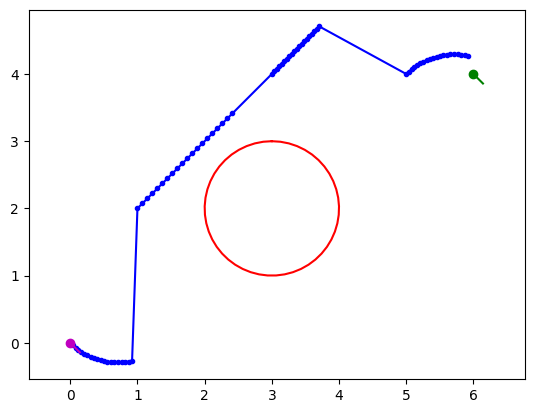

In [30]:
# define decision variable as vector of [time,curv,state,time,curv,state,time,curv]
zmo = np.array([1.,1.,   1.,2.,np.pi/4,2.,0.,   3.,4.,np.pi/4,1.,-0.,   5.,4.,np.pi/4,1.,-1.])
#zmo = np.array([1.,1.,   1.5,-0.5,0.5*np.pi/4,3.,0.,   4.5,1.,2.0*np.pi/4,2.5,0.,   5.,4.,2.0*np.pi/4,2.,-1.])

c_obs = np.array([3,2])
r_obs = 1.
ths = np.linspace(0.,2*np.pi,50)
plt.plot(c_obs[0]+r_obs*np.array([sin(th) for th in ths]),c_obs[1]+r_obs*np.array([cos(th) for th in ths]),'r-')

p = pathm(zmo)

plt.plot(p[:,0],p[:,1],'-b.')
plot_pose(x0,'m')
plot_pose(xG,'g')
plt.axis('equal')
plt.show()

In [31]:
def Jmo(z):
    tf = sum(z[range(0,len(z),5)])
    p = pathm(z)
    ge = norm(xG-p[-1,:])
    for ii in range(20,len(p)-1,20):
        ge=ge+norm(p[ii,:]-p[ii+1,:])
    op = 0.
    for pp in p:
        inc = r_obs - norm(pp[0:2]-c_obs)
        if inc>0:
            op = op + inc
    return(0.1*tf+100.*ge + 50.*op)

print(Jmo(zm))

632.4732524609318


In [32]:
bndsmo = [b for ii in range((7+len(zmo))//5) for b in [(0.1,10.0),(--curvature_limit,curvature_limit),(-x_lim,x_lim),(-x_lim,x_lim),(-th_lim,th_lim)]]
bndsmo = bndsmo[0:-3]
assert(len(bndsmo)==len(zmo))
bndsmo

[(0.1, 10.0),
 (1.5, 1.5),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (0.1, 10.0),
 (1.5, 1.5),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (0.1, 10.0),
 (1.5, 1.5),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (0.1, 10.0),
 (1.5, 1.5)]

In [33]:
r = minimize(Jmo,zmo,method='SLSQP',bounds=bndsmo)
print(r)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 636.4606800303626
       x: [ 1.108e+00  1.500e+00 ...  1.155e-01  1.500e+00]
     nit: 24
     jac: [-3.109e+01        nan ...  1.083e+01        nan]
    nfev: 385
    njev: 24


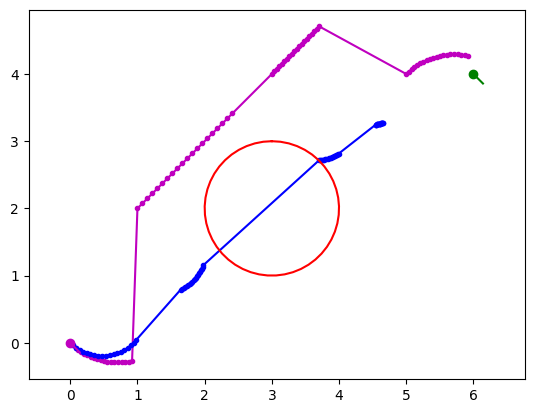

In [34]:
popt = pathm(r.x)

plt.plot(p[:,0],p[:,1],'-m.')
plt.plot(popt[:,0],popt[:,1],'-b.')
plt.plot(c_obs[0]+r_obs*np.array([sin(th) for th in ths]),c_obs[1]+r_obs*np.array([cos(th) for th in ths]),'r-')
plot_pose(x0,'m')
plot_pose(xG,'g')
plt.axis('equal')
plt.show()